# Probablistic model building genetic algorithm

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from src.neural_search import search_env, get_reward_pipeline
from src.data import load_finkelstein_data
from src.reload import reload_from_dir

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
(x_train, y_train), (x_test, y_test) = load_finkelstein_data(
    target='wtCas9_cleave_rate_log', 
    include_ref=True,
    logbase=10
)

## Setup AMBER

In [5]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.2-pmbga


In [6]:
def get_cas9_finkelstein_ms(use_sink_state=False):
    """model space based on https://www.biorxiv.org/content/10.1101/2020.05.21.108613v2
    """
    ks_choices=[1,2,3]
    kinn_model_space = ModelSpace.from_dict([
        # k_on, sol -> open R-loop
        [dict(Layer_type='conv1d', filters=1, SOURCE='0', TARGET='1',
              kernel_size=3,
              padding="valid",
              EDGE=1,
              RANGE_ST=0,
              RANGE_D=3,
         )],
        # k_off, open R-loop -> sol
        [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='0', 
              kernel_size=3,
              padding="valid",
              EDGE=1,
              RANGE_ST=0,
              RANGE_D=3
         )],
        # k_OI, open R-loop -> intermediate R-loop
        [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='2',
              kernel_size=pmbga.Categorical(choices=ks_choices, prior_cnt=1),
              padding="same",
              EDGE=1,
              RANGE_ST=pmbga.Categorical(choices=[3,4,5,6,7,8,9,10,11,12,13,14,15],
                  prior_cnt=1),
              RANGE_D=pmbga.Categorical(choices=[5,6,7,8,9,10,11,12,13,14,15], prior_cnt=1)
         )],
        # k_IO, intermediate R-loop -> open R-loop
        [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='1',
              kernel_size=pmbga.Categorical(choices=ks_choices, prior_cnt=1),
              padding="same",
              EDGE=1,
              RANGE_ST=pmbga.Categorical(choices=[3,4,5,6,7,8,9,10,11,12,13,14,15],
                  prior_cnt=1),
              RANGE_D=pmbga.Categorical(choices=[5,6,7,8,9,10,11,12,13,14,15], prior_cnt=1)
         )],
        # k_IC, intermediate R-loop -> closed R-loop
        [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='3',
              kernel_size=pmbga.Categorical(choices=ks_choices, prior_cnt=1),
              padding="same",
              EDGE=1,
              RANGE_ST=pmbga.Categorical(choices=[10,11,12,13,14,15,16,17,18,19,20,], prior_cnt=1),
              RANGE_D=pmbga.Categorical(choices=[5,6,7,8,9,10,11,12,13,14,15], prior_cnt=1)
         )],
        # k_CI, closed R-loop -> intermediate R-loop
        [dict(Layer_type='conv1d', filters=1, SOURCE='3', TARGET='2',
              kernel_size=pmbga.Categorical(choices=ks_choices, prior_cnt=1),
              padding="same",
              EDGE=1,
              RANGE_ST=pmbga.Categorical(choices=[10,11,12,13,14,15,16,17,18,19,20,], prior_cnt=1),
              RANGE_D=pmbga.Categorical(choices=[5,6,7,8,9,10,11,12,13,14,15], prior_cnt=1)
         )],
        # k_30 for cycle, k_34 for sink
        [dict(Layer_type='conv1d', filters=1, SOURCE='3', TARGET='4' if use_sink_state else '0',
              kernel_size=pmbga.Categorical(choices=ks_choices, prior_cnt=1),
              padding="same",
              EDGE=1,
              RANGE_ST=pmbga.Categorical(choices=np.arange(0,23-5), prior_cnt=1),
              RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),
              #RANGE_D=pmbga.Categorical(choices=np.arange(7,15), prior_cnt=1),
              CONTRIB=1
         )],
    ])
    return kinn_model_space

def get_cas9_finkelstein_ms_with_hidden(use_sink_state=False):
    ms = get_cas9_finkelstein_ms(use_sink_state=use_sink_state)
    for layer in ms:
        assert len(layer) == 1
        layer[0].Layer_attributes['filters'] = pmbga.Categorical(choices=[1,2,3], prior_cnt=1)
        layer[0].Layer_attributes['hidden_size'] = pmbga.Categorical(choices=[0,3], prior_cnt=[1,1])
        layer[0].Layer_attributes['reshape_fn'] = pmbga.Categorical(choices=[0,1,2], prior_cnt=1)
    return ms

In [7]:
kinn_model_space = get_cas9_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,   # buffer size controlls the max history going back
            batch_size=1,      # batch size does not matter in this case; all arcs will be retrieved
            ewa_beta=0.6,      # ewa_beta approximates the moving average over 1/(1-ewa_beta) prev points
)

## search env

In [9]:
# trainEnv parameters
samps_per_gen = 5   # how many arcs to sample in each generation; important
max_gen = 1000
patience = 300
n_warmup_gen = 0
wd = "outputs/notebook_wtCas9"

In [10]:
# trainEnv parameters
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
    samps_per_gen = samps_per_gen,   # how many arcs to sample in each generation; important
    max_gen = max_gen,
    patience = patience,
    n_warmup_gen = 0,
    train_data = (x_train, y_train),
    test_data = (x_test, y_test)
)

# manager configs
# this learning rate is trickier than usual, for eigendecomp to work
initial_learning_rate = 0.01
batch_size = 768
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(7000/batch_size), # decrease every 5 epochs
    decay_rate=0.9,
    staircase=True)

logbase = 10
if logbase is None:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: x, name="output_nominal")
else:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(logbase), name="output_log")

n_channels = 13
manager_kwargs={
    'optimizer': lambda: tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.),
    'output_op': output_op,
    'n_feats': 25,
    'n_channels': n_channels,
    'batch_size': batch_size,
    'epochs': 300,
    'earlystop': 30,
    'verbose': 0
}

In [11]:
controller, hist, stat_df = search_env(
    controller=controller, 
    wd = wd,
    evo_params=evo_params, 
    manager_kwargs=manager_kwargs
)

datapoints:  2 / total:  5
[04:00:25] Gen 0 - Mean fitness 0.713 - Best 0.7529 - PostVar 8.047 - Time 54.64
datapoints:  8 / total:  10
[04:01:04] Gen 1 - Mean fitness 0.659 - Best 0.7529 - PostVar 7.372 - Time 39.16
datapoints:  11 / total:  15
[04:01:37] Gen 2 - Mean fitness 0.525 - Best 0.7529 - PostVar 7.605 - Time 33.00
datapoints:  15 / total:  20
[04:02:22] Gen 3 - Mean fitness 0.550 - Best 0.7529 - PostVar 7.537 - Time 44.69
datapoints:  20 / total:  25
[04:03:18] Gen 4 - Mean fitness 0.621 - Best 0.7695 - PostVar 7.246 - Time 56.13
datapoints:  24 / total:  30
[04:04:09] Gen 5 - Mean fitness 0.589 - Best 0.7695 - PostVar 7.801 - Time 51.24
datapoints:  29 / total:  35
[04:05:02] Gen 6 - Mean fitness 0.632 - Best 0.7695 - PostVar 7.140 - Time 53.25
datapoints:  29 / total:  40
[04:05:58] Gen 7 - Mean fitness 0.672 - Best 0.7695 - PostVar 7.716 - Time 55.79
datapoints:  30 / total:  45
[04:06:46] Gen 8 - Mean fitness 0.689 - Best 0.7695 - PostVar 7.838 - Time 48.28
datapoints:  

datapoints:  207 / total:  250
[05:01:48] Gen 74 - Mean fitness 0.591 - Best 0.8092 - PostVar 7.131 - Time 50.49
datapoints:  200 / total:  250
[05:02:47] Gen 75 - Mean fitness 0.652 - Best 0.8092 - PostVar 6.766 - Time 59.14
datapoints:  208 / total:  250
[05:03:22] Gen 76 - Mean fitness 0.549 - Best 0.8092 - PostVar 6.985 - Time 34.73
datapoints:  207 / total:  250
[05:04:11] Gen 77 - Mean fitness 0.584 - Best 0.8092 - PostVar 7.149 - Time 49.20
datapoints:  206 / total:  250
[05:04:56] Gen 78 - Mean fitness 0.572 - Best 0.8092 - PostVar 7.427 - Time 45.52
datapoints:  204 / total:  250
[05:05:38] Gen 79 - Mean fitness 0.569 - Best 0.8092 - PostVar 6.855 - Time 41.19
datapoints:  203 / total:  250
[05:06:27] Gen 80 - Mean fitness 0.580 - Best 0.8092 - PostVar 7.667 - Time 49.59
datapoints:  202 / total:  250
[05:07:16] Gen 81 - Mean fitness 0.582 - Best 0.8092 - PostVar 6.991 - Time 48.84
datapoints:  198 / total:  250
[05:08:12] Gen 82 - Mean fitness 0.633 - Best 0.8092 - PostVar 6.

datapoints:  209 / total:  250
[06:03:57] Gen 147 - Mean fitness 0.664 - Best 0.8092 - PostVar 7.016 - Time 51.16
datapoints:  187 / total:  250
[06:04:46] Gen 148 - Mean fitness 0.697 - Best 0.8092 - PostVar 6.207 - Time 49.29
datapoints:  173 / total:  250
[06:05:39] Gen 149 - Mean fitness 0.710 - Best 0.8092 - PostVar 6.486 - Time 52.88
datapoints:  140 / total:  250
[06:06:41] Gen 150 - Mean fitness 0.730 - Best 0.8092 - PostVar 6.398 - Time 61.56
datapoints:  146 / total:  250
[06:07:27] Gen 151 - Mean fitness 0.727 - Best 0.8092 - PostVar 6.152 - Time 46.39
datapoints:  198 / total:  250
[06:08:10] Gen 152 - Mean fitness 0.688 - Best 0.8092 - PostVar 7.128 - Time 42.45
datapoints:  176 / total:  250
[06:08:59] Gen 153 - Mean fitness 0.711 - Best 0.8092 - PostVar 6.940 - Time 49.46
datapoints:  149 / total:  250
[06:10:05] Gen 154 - Mean fitness 0.727 - Best 0.8092 - PostVar 6.128 - Time 66.02
datapoints:  125 / total:  250
[06:11:04] Gen 155 - Mean fitness 0.741 - Best 0.8092 - P

datapoints:  128 / total:  250
[07:08:37] Gen 219 - Mean fitness 0.744 - Best 0.8205 - PostVar 6.415 - Time 51.43
datapoints:  119 / total:  250
[07:09:43] Gen 220 - Mean fitness 0.748 - Best 0.8205 - PostVar 6.308 - Time 65.73
datapoints:  181 / total:  250
[07:10:38] Gen 221 - Mean fitness 0.711 - Best 0.8205 - PostVar 6.379 - Time 54.77
datapoints:  215 / total:  250
[07:11:22] Gen 222 - Mean fitness 0.664 - Best 0.8205 - PostVar 6.818 - Time 44.00
datapoints:  216 / total:  250
[07:12:14] Gen 223 - Mean fitness 0.630 - Best 0.8205 - PostVar 6.228 - Time 52.18
datapoints:  216 / total:  250
[07:13:15] Gen 224 - Mean fitness 0.635 - Best 0.8205 - PostVar 5.873 - Time 60.53
datapoints:  215 / total:  250
[07:14:08] Gen 225 - Mean fitness 0.623 - Best 0.8205 - PostVar 6.741 - Time 53.45
datapoints:  213 / total:  250
[07:15:19] Gen 226 - Mean fitness 0.665 - Best 0.8205 - PostVar 6.551 - Time 70.71
datapoints:  192 / total:  250
[07:16:10] Gen 227 - Mean fitness 0.698 - Best 0.8205 - P

datapoints:  220 / total:  250
[08:14:06] Gen 291 - Mean fitness 0.674 - Best 0.8205 - PostVar 6.500 - Time 58.83
datapoints:  227 / total:  250
[08:15:06] Gen 292 - Mean fitness 0.638 - Best 0.8205 - PostVar 6.217 - Time 60.18
datapoints:  216 / total:  250
[08:16:07] Gen 293 - Mean fitness 0.676 - Best 0.8205 - PostVar 6.265 - Time 60.66
datapoints:  227 / total:  250
[08:16:41] Gen 294 - Mean fitness 0.604 - Best 0.8205 - PostVar 6.229 - Time 33.75
datapoints:  224 / total:  250
[08:17:30] Gen 295 - Mean fitness 0.657 - Best 0.8205 - PostVar 6.722 - Time 49.20
datapoints:  224 / total:  250
[08:18:18] Gen 296 - Mean fitness 0.648 - Best 0.8205 - PostVar 6.377 - Time 47.90
datapoints:  210 / total:  250
[08:19:29] Gen 297 - Mean fitness 0.687 - Best 0.8205 - PostVar 7.070 - Time 71.15
datapoints:  193 / total:  250
[08:20:29] Gen 298 - Mean fitness 0.708 - Best 0.8205 - PostVar 6.374 - Time 60.36
datapoints:  211 / total:  250
[08:21:26] Gen 299 - Mean fitness 0.679 - Best 0.8205 - P

datapoints:  207 / total:  250
[09:18:54] Gen 363 - Mean fitness 0.686 - Best 0.8205 - PostVar 7.172 - Time 52.73
datapoints:  192 / total:  250
[09:19:46] Gen 364 - Mean fitness 0.707 - Best 0.8205 - PostVar 6.645 - Time 52.06
datapoints:  182 / total:  250
[09:20:42] Gen 365 - Mean fitness 0.718 - Best 0.8205 - PostVar 6.122 - Time 56.04
datapoints:  153 / total:  250
[09:21:37] Gen 366 - Mean fitness 0.737 - Best 0.8205 - PostVar 6.780 - Time 54.77
datapoints:  207 / total:  250
[09:22:22] Gen 367 - Mean fitness 0.688 - Best 0.8205 - PostVar 6.473 - Time 45.04
datapoints:  183 / total:  250
[09:23:16] Gen 368 - Mean fitness 0.720 - Best 0.8205 - PostVar 6.344 - Time 54.30
datapoints:  146 / total:  250
[09:24:13] Gen 369 - Mean fitness 0.739 - Best 0.8205 - PostVar 6.293 - Time 56.45
datapoints:  209 / total:  250
[09:25:07] Gen 370 - Mean fitness 0.687 - Best 0.8205 - PostVar 5.887 - Time 53.68
datapoints:  201 / total:  250
[09:25:59] Gen 371 - Mean fitness 0.696 - Best 0.8205 - P

datapoints:  193 / total:  250
[10:24:15] Gen 435 - Mean fitness 0.711 - Best 0.8205 - PostVar 6.464 - Time 57.54
datapoints:  218 / total:  250
[10:25:06] Gen 436 - Mean fitness 0.669 - Best 0.8205 - PostVar 6.682 - Time 51.92
datapoints:  205 / total:  250
[10:25:58] Gen 437 - Mean fitness 0.695 - Best 0.8205 - PostVar 6.044 - Time 51.40
datapoints:  169 / total:  250
[10:27:16] Gen 438 - Mean fitness 0.729 - Best 0.8205 - PostVar 6.407 - Time 77.60
datapoints:  166 / total:  250
[10:28:17] Gen 439 - Mean fitness 0.730 - Best 0.8205 - PostVar 6.256 - Time 61.64
datapoints:  201 / total:  250
[10:29:18] Gen 440 - Mean fitness 0.701 - Best 0.8205 - PostVar 5.777 - Time 60.67
datapoints:  207 / total:  250
[10:30:05] Gen 441 - Mean fitness 0.685 - Best 0.8205 - PostVar 6.580 - Time 46.71
datapoints:  211 / total:  250
[10:30:51] Gen 442 - Mean fitness 0.677 - Best 0.8205 - PostVar 6.192 - Time 46.12
datapoints:  211 / total:  250
[10:31:41] Gen 443 - Mean fitness 0.676 - Best 0.8205 - P

datapoints:  217 / total:  250
[11:31:22] Gen 507 - Mean fitness 0.676 - Best 0.8205 - PostVar 5.935 - Time 53.31
datapoints:  205 / total:  250
[11:32:20] Gen 508 - Mean fitness 0.701 - Best 0.8205 - PostVar 6.299 - Time 58.13
datapoints:  214 / total:  250
[11:33:11] Gen 509 - Mean fitness 0.690 - Best 0.8205 - PostVar 6.521 - Time 50.61


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


early-stop due to max patience w/o improvement


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


In [12]:
pd.DataFrame(hist).sort_values('test_reward', ascending=False)

,gen,arc,test_reward,rate_df
1046,209,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.820488,None
1207,241,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.819226,None
2354,470,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.809655,None
53,10,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.809197,None
2191,438,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.808460,None
...,...,...,...,...
684,136,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.169574,None
394,78,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.177597,None
2096,419,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.228483,None
119,23,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.249848,None


In [13]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_reward', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 15}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 2, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 4, 'RANGE_D': 14}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 3, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 17, 'RANGE_D': 5}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 20, 'RANGE_D': 15}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 3, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 1, 'RANGE_D': 6, 'CONTRIB': 1}


In [14]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

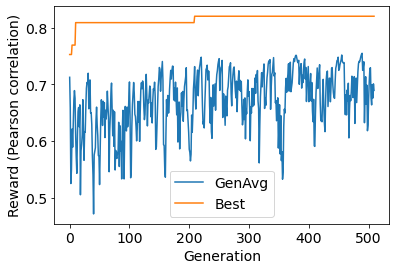

In [15]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

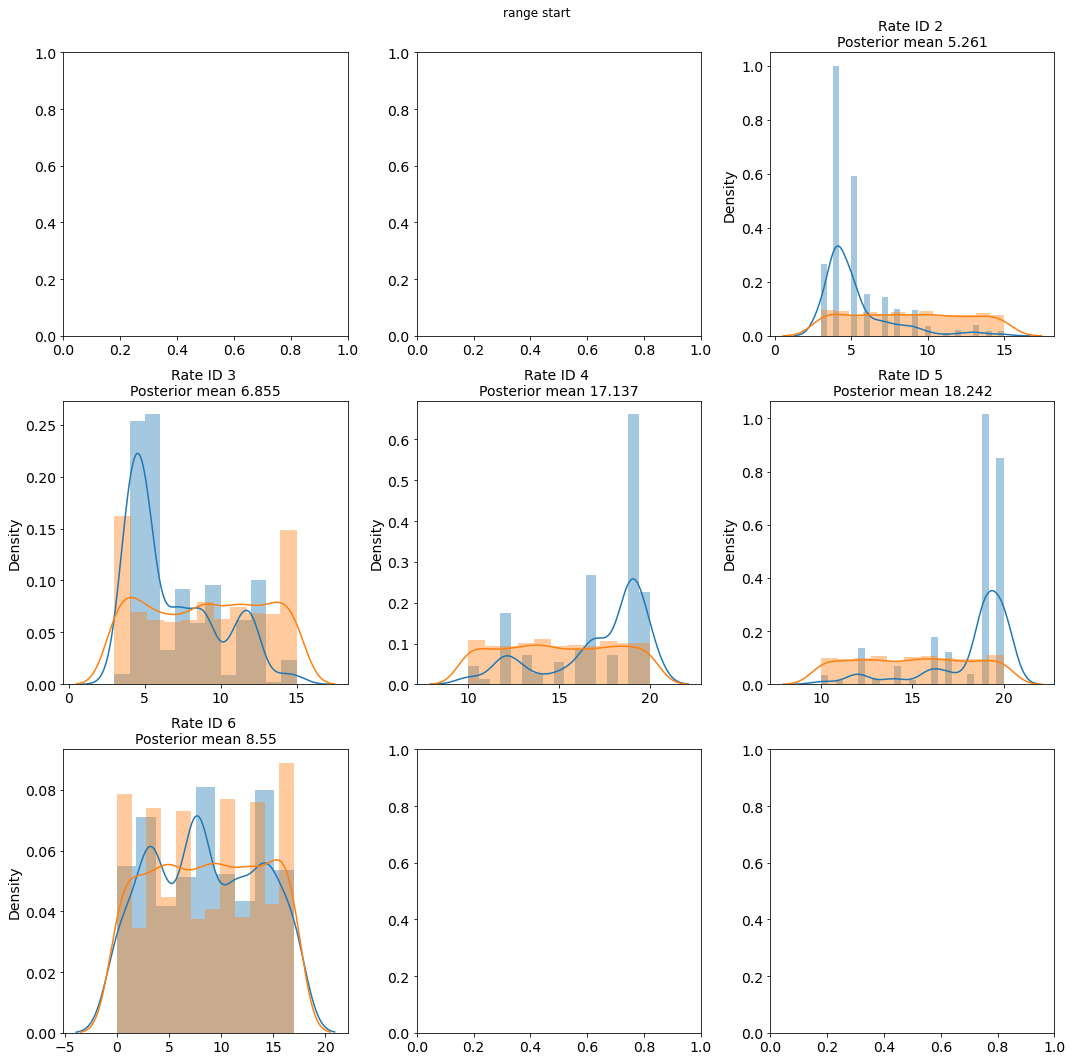

In [16]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

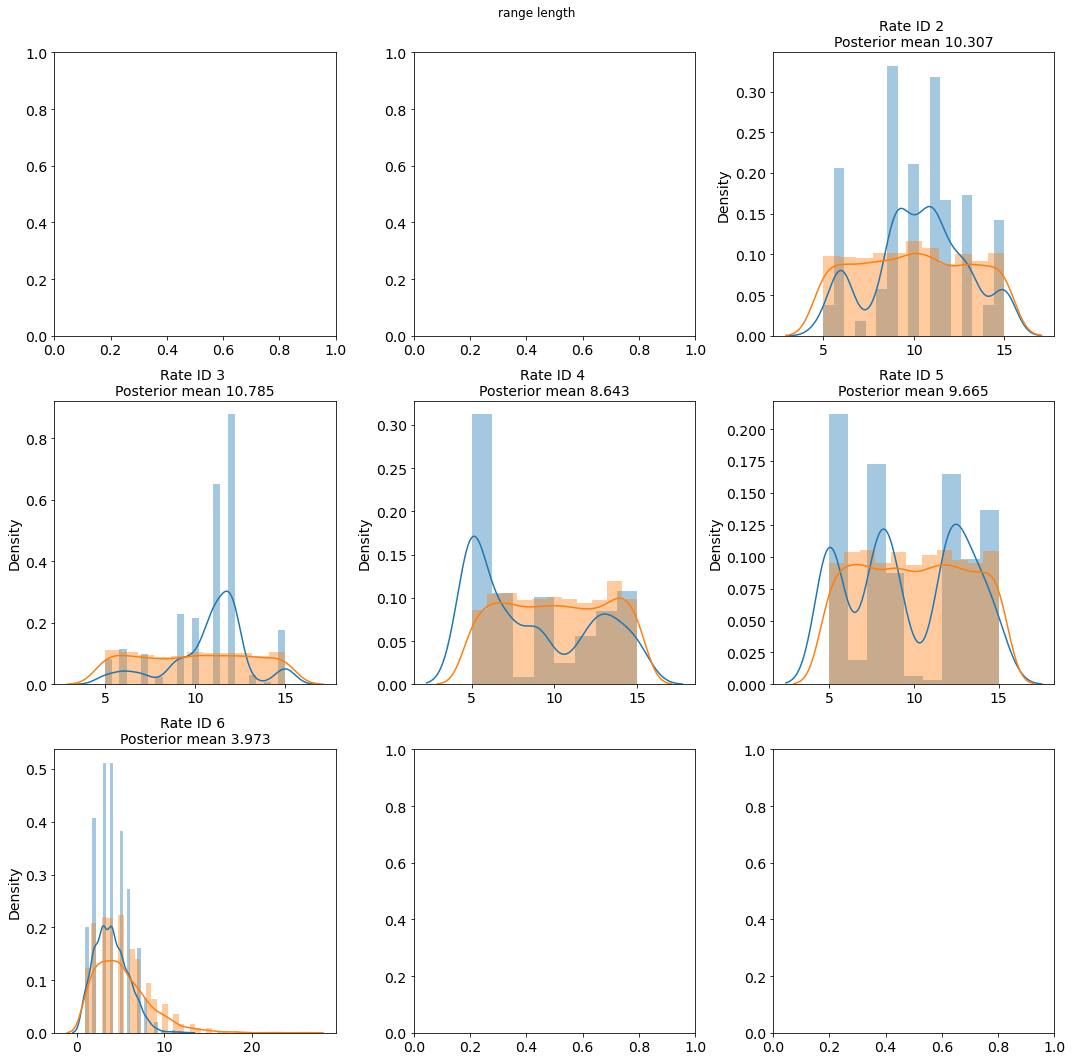

In [17]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

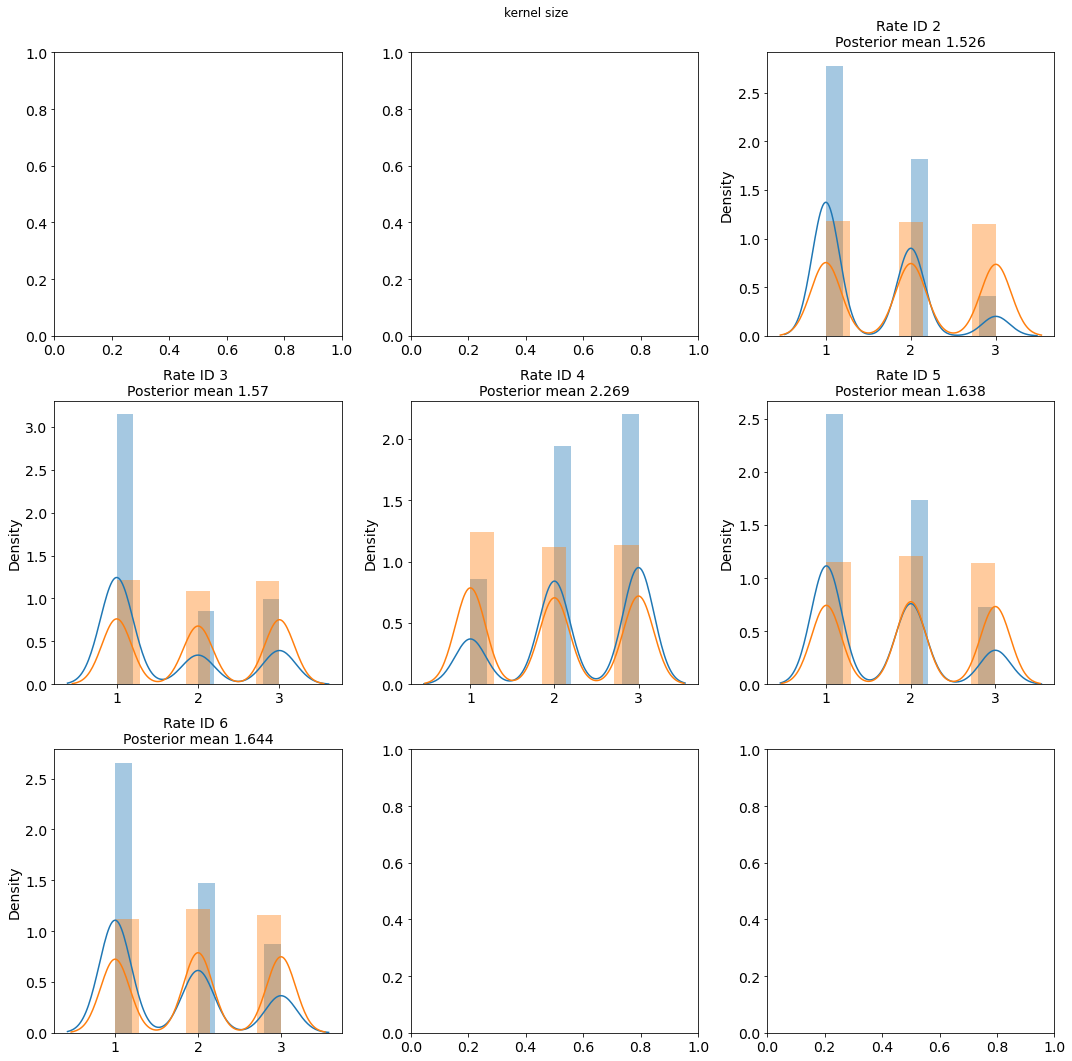

In [18]:
# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20) 
fig.suptitle('kernel size')
fig.tight_layout()

In [19]:
pickle.load(open(os.path.join(wd,"AmberSearchBestModel_config.pkl"), "rb"))

{'States': ['0', '1', '2', '3'],
 'Rates': [{'name': 'k_01',
   'state_list': ['0', '1'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'scatter_nd': [((0, 0), -1), ((1, 0), 1)],
   'filters': 1,
   'SOURCE': '0',
   'TARGET': '1',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_10',
   'state_list': ['1', '0'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'scatter_nd': [((1, 1), -1), ((0, 1), 1)],
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '0',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_12',
   'state_list': ['1', '2'],
   'input_range': [3, 18],
   'kernel_size': 1,
   'scatter_nd': [((1, 1), -1), ((2, 1), 1)],
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '2',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 3,
   'RANGE_D': 15},
  {'name': 'k_21',
   'state_list': ['2', '1'],
   'input_range': [4, 18],
   'kernel_size': 2,
   'scatter_nd': [((2, 2), -1), ((1, 2), 1)],
   'filters': 

In [20]:
mb = reload_from_dir(wd, manager_kwargs=manager_kwargs)
model = mb.model

In [21]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None, 'mat': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None, 'mat': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [3, 18], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 15, 'template': None, 'mat': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [4, 18], 'kernel_size': 2, 'scatter_nd': [((2, 2), -1), ((1, 2), 1)], 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 

In [22]:
layer_dict = {l.name:l for l in model.layers}

In [23]:
np.around(layer_dict['conv_k0'].get_weights()[0],2)

array([[[ 0.  ],
        [ 0.  ],
        [-0.38],
        [ 0.  ],
        [-2.43],
        [-3.39],
        [ 0.  ],
        [-3.45],
        [-0.2 ],
        [-0.18],
        [ 0.37],
        [-0.31],
        [-2.85]],

       [[ 0.  ],
        [ 0.  ],
        [-0.38],
        [ 0.  ],
        [-1.77],
        [-3.03],
        [ 0.  ],
        [-2.68],
        [-1.18],
        [-2.33],
        [ 0.  ],
        [-1.48],
        [ 0.  ]],

       [[ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [-0.38],
        [ 1.22],
        [ 1.09],
        [ 2.06],
        [ 0.  ],
        [ 0.09],
        [-1.92],
        [-0.99],
        [-1.68],
        [ 0.71]]], dtype=float32)

In [24]:
np.around(layer_dict['conv_k1'].get_weights()[0],2)

array([[[ 0.  ],
        [ 0.  ],
        [ 0.44],
        [ 0.  ],
        [ 2.42],
        [ 3.38],
        [ 0.  ],
        [ 3.45],
        [ 0.22],
        [ 0.2 ],
        [-0.31],
        [ 0.32],
        [ 2.85]],

       [[ 0.  ],
        [ 0.  ],
        [ 0.44],
        [ 0.  ],
        [ 1.77],
        [ 3.03],
        [ 0.  ],
        [ 2.68],
        [ 1.17],
        [ 2.32],
        [ 0.  ],
        [ 1.48],
        [ 0.  ]],

       [[ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.44],
        [-1.18],
        [-1.05],
        [-2.04],
        [ 0.  ],
        [-0.09],
        [ 1.92],
        [ 0.98],
        [ 1.68],
        [-0.71]]], dtype=float32)

spearman SpearmanrResult(correlation=0.7766563641799406, pvalue=0.0)
pearson (0.820487732047218, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.820')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


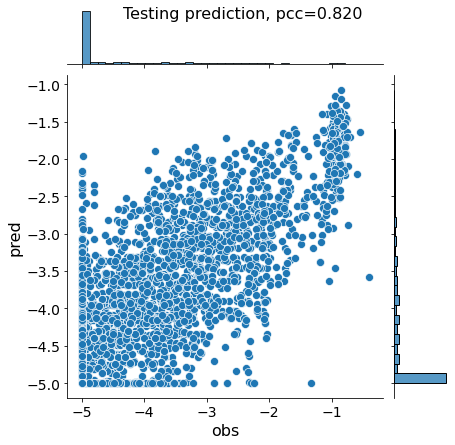

In [25]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 09 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

numpy     : 1.21.6
pandas    : 1.3.5
tensorflow: 1.15.0
seaborn   : 0.11.1
amber     : 0.1.2-pmbga
scipy     : 1.7.3
matplotlib: 3.4.3

Watermark: 2.3.1

